<a href="https://colab.research.google.com/github/RasheedKhan123/KNN/blob/main/Knn_and_logisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearn.datasets import load_breast_cancer
import numpy as np
from sklearn.metrics import log_loss
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [ ]:
def min_max_scale(X):
    return (X-X.min())/(X.max()-X.min())

def train_test_split(X, y, train_ratio):
    # Method to split the data into training and testing sets based on the provided ratio
    order = np.array(range(X.shape[0]))
    np.random.shuffle(order)
    X_shuffled = X[order, :]
    y_shuffled = y[order]
    train_size = int(X.shape[0] * train_ratio)
    X_train, X_test = X[order, :][:train_size, :].copy(), X[order, :][train_size:, :].copy()
    y_train, y_test = y[order][:train_size].copy(), y[order][train_size:].copy()
    return X_train, y_train, X_test, y_test

def my_mse(y_pred,y):
    return np.dot(y - y_pred, y - y_pred) / len(y)


def cross_validate(X, y, model, lambda_values, k):
    X_split = np.array_split(X, k)
    y_split = np.array_split(y, k)
    best_lambda = None
    best_avg_error = float('inf')  # Initialize with a large value

    for lambd in lambda_values:
        avg_error = 0

        for ind in range(k):
            X_val, y_val = X_split[ind], y_split[ind]
            X_train = np.vstack(X_split[:ind] + X_split[ind + 1:])
            y_train = np.concatenate(y_split[:ind] + y_split[ind + 1:])

            # Train the model with Ridge Regression using the current lambda value
            val_beta = model.gradient_descent(X_train, y_train, lambda_reg=lambd, lr=0.01,tol = 0.01)

            # Make predictions on the validation set
            val_predictions = X_val @ val_beta.flatten()

            # Calculate the mean squared error (MSE)
            mse = my_mse(val_predictions, y_val)

            avg_error += mse

        avg_error /= k

        # Check if the current lambda gives a lower average error
        if np.mean(avg_error) < np.mean(best_avg_error):
            best_avg_error = avg_error
            best_lambda = lambd


    return best_lambda

def TPR_FPR(y_pred, y_true):
    y_comp = np.vstack([y_pred, y_true]).T
    TP = ((y_comp[:,0]==1) & (y_comp[:,1]==1)).astype(int).sum()
    TN = ((y_comp[:,0]==0) & (y_comp[:,1]==0)).astype(int).sum()
    FN = ((y_comp[:,0]==0) & (y_comp[:,1]==1)).astype(int).sum()
    FP = ((y_comp[:,0]==1) & (y_comp[:,1]==0)).astype(int).sum()
    TPR, FPR = TP/(TP + FN), FP/(FP + TN)
    return [TPR, FPR]


def calculate_roc(y_true, y_scores):
    thresholds = np.unique(y_scores)
    thresholds = np.append(thresholds, thresholds[-1] + 1)  # Ensure the last threshold includes all scores

    tpr_list = []
    fpr_list = []

    total_positives = np.sum(y_true == 1)
    total_negatives = np.sum(y_true == 0)

    for threshold in thresholds:
        y_pred = (y_scores >= threshold).astype(int)

        true_positives = np.sum((y_true == 1) & (y_pred == 1))
        false_positives = np.sum((y_true == 0) & (y_pred == 1))

        tpr = true_positives / total_positives
        fpr = false_positives / total_negatives

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list)

def calculate_auc(fpr, tpr):
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    auc_value = np.trapz(tpr_sorted, fpr_sorted)
    return auc_value

def plot_roc_curve(fpr, tpr, auc_value):
    plt.figure(figsize=(8, 8))

    # Plot ROC curve
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')

    # Plot diagonal line
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Annotate AUC value on the plot
    plt.annotate(f'AUC = {auc_value:.2f}', xy=(0.6, 0.2), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='black', shrink=0.05), bbox=dict(facecolor='white', alpha=0.5))

    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
class myLogisticRegression:

    def sigmoid(self,X,beta):
        return 1/ (1+ np.exp(-np.matmul(X, beta)))

    def f_dev(self, X, y, theta, lambda_reg=None):
      m = len(y)
      h = self.sigmoid(X, theta)
      error = h - y
      gradient_derivative = (1/m) * np.dot(X.T, error)
      #gradient_derivative = gradient_derivative.reshape(-1,1)

      if lambda_reg is not None:
          regularization_term = (2 * lambda_reg / m) * theta
          regularization_term[0] = 0  # Exclude regularization for bias term
          regularization_term = regularization_term.reshape(-1, 1)  # Ensure column vector
          gradient_derivative += regularization_term.flatten()

      return gradient_derivative

    def gradient_descent(self,X, y, lr, tol,lambda_reg = None):
        beta = np.zeros(shape = X.shape[1])
        while True:
            gradient = self.f_dev(X,y,theta = beta,lambda_reg = lambda_reg)
            if np.max(np.abs(gradient)) < tol:
                break
            beta = beta - gradient * lr
        return beta


    def TPR_FPR(self,y_pred, y_true):
        y_comp = np.vstack([y_pred, y_true]).T
        TP = ((y_comp[:,0]==1) & (y_comp[:,1]==1)).astype(int).sum()
        TN = ((y_comp[:,0]==0) & (y_comp[:,1]==0)).astype(int).sum()
        FN = ((y_comp[:,0]==0) & (y_comp[:,1]==1)).astype(int).sum()
        FP = ((y_comp[:,0]==1) & (y_comp[:,1]==0)).astype(int).sum()
        TPR, FPR = TP/(TP + FN), FP/(FP + TN)
        return [TPR, FPR]

    def evaluate_classification_model(self, y_true, y_pred, probability_cutoffs=None):
        if probability_cutoffs is None:
            probability_cutoffs = np.linspace(0, 1, 101)

        tpr_values = []
        fpr_values = []
        cm_values = []

        for cutoff in probability_cutoffs:
            # Calculate confusion matrix
            y_pred_binary = (y_pred >= cutoff).astype(int)
            cm = np.array([[np.sum((y_true == 0) & (y_pred_binary == 0)), np.sum((y_true == 0) & (y_pred_binary == 1))],
                           [np.sum((y_true == 1) & (y_pred_binary == 0)), np.sum((y_true == 1) & (y_pred_binary == 1))]])

            # TPR and FPR
            tpr, fpr = self.TPR_FPR(y_pred_binary, y_true)

            tpr_values.append(tpr)
            fpr_values.append(fpr)
            cm_values.append(cm)

        # ROC curve and AUC (Not affected by custom confusion matrix)
        '''

# Plot ROC curve
'''
        fpr_custom, tpr_custom = calculate_roc(y_true, y_pred)
        auc_value_custom = calculate_auc(fpr_custom, tpr_custom)

        # Plot ROC curve
        plot_roc_curve(fpr_custom, tpr_custom, auc_value_custom)

        return cm_values, auc_value_custom, tpr_values, fpr_values

In [ ]:
class knn:
# algo
        # for point in X:
            #   dist(point, all_points_X)
            #   select the 4 points with lowest distances
            #   look at the ground truth
            #   compute the prob(y=1)
    def myKnn(self,X, y, k):
      predictions = []
      probabilities = []

      for point in X:
          dist = np.linalg.norm(X - point, axis=1)
          points = np.argsort(dist)[:k]

          # Compute the prediction as the mean of y values
          prediction = np.mean(y[points])
          predictions.append(prediction)

          # Compute the probability as the fraction of positive samples in the selected points
          probability = np.sum(y[points] == 1) / k
          probabilities.append(probability)

      return np.array(predictions), np.array(probabilities)

    def TPR_FPR(self,y_pred, y_true):
        y_comp = np.vstack([y_pred, y_true]).T
        TP = ((y_comp[:,0]==1) & (y_comp[:,1]==1)).astype(int).sum()
        TN = ((y_comp[:,0]==0) & (y_comp[:,1]==0)).astype(int).sum()
        FN = ((y_comp[:,0]==0) & (y_comp[:,1]==1)).astype(int).sum()
        FP = ((y_comp[:,0]==1) & (y_comp[:,1]==0)).astype(int).sum()
        TPR, FPR = TP/(TP + FN), FP/(FP + TN)
        return [TPR, FPR]

    def evaluate_classification_model(self, y_true, y_pred, probability_cutoffs=None):
        if probability_cutoffs is None:
            probability_cutoffs = np.linspace(0, 1, 101)

        tpr_values = []
        fpr_values = []
        cm_values = []

        for cutoff in probability_cutoffs:
            # Calculate confusion matrix
            y_pred_binary = (y_pred >= cutoff).astype(int)
            cm = np.array([[np.sum((y_true == 0) & (y_pred_binary == 0)), np.sum((y_true == 0) & (y_pred_binary == 1))],
                           [np.sum((y_true == 1) & (y_pred_binary == 0)), np.sum((y_true == 1) & (y_pred_binary == 1))]])

            # TPR and FPR
            tpr, fpr = self.TPR_FPR(y_pred_binary, y_true)

            tpr_values.append(tpr)
            fpr_values.append(fpr)
            cm_values.append(cm)

        # ROC curve and AUC (Not affected by custom confusion matrix)
        '''

# Plot ROC curve
'''
        fpr_custom, tpr_custom = calculate_roc(y_true, y_pred)
        auc_value_custom = calculate_auc(fpr_custom, tpr_custom)

        # Plot ROC curve
        plot_roc_curve(fpr_custom, tpr_custom, auc_value_custom)

        return cm_values, auc_value_custom, tpr_values, fpr_values

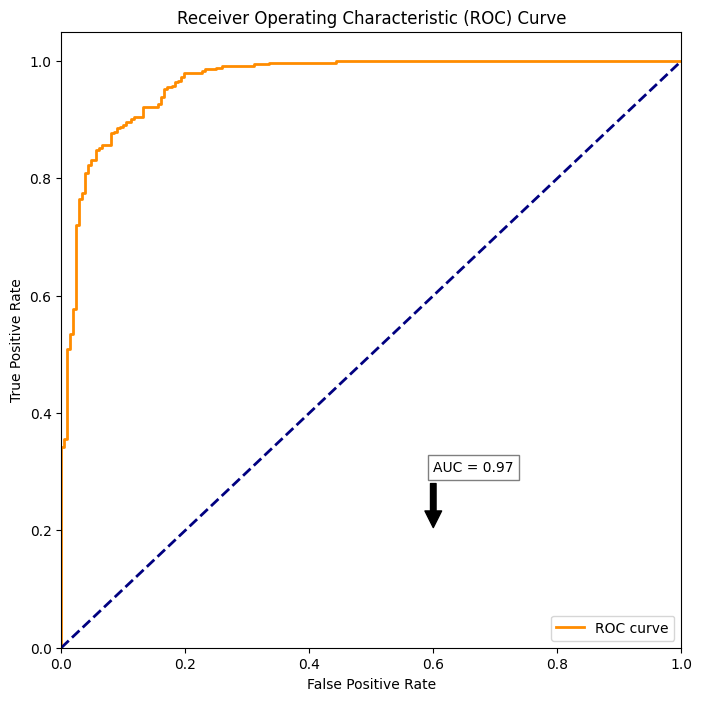

AUC: 0.9654220178637494
BEST LAMBDA: 1.0


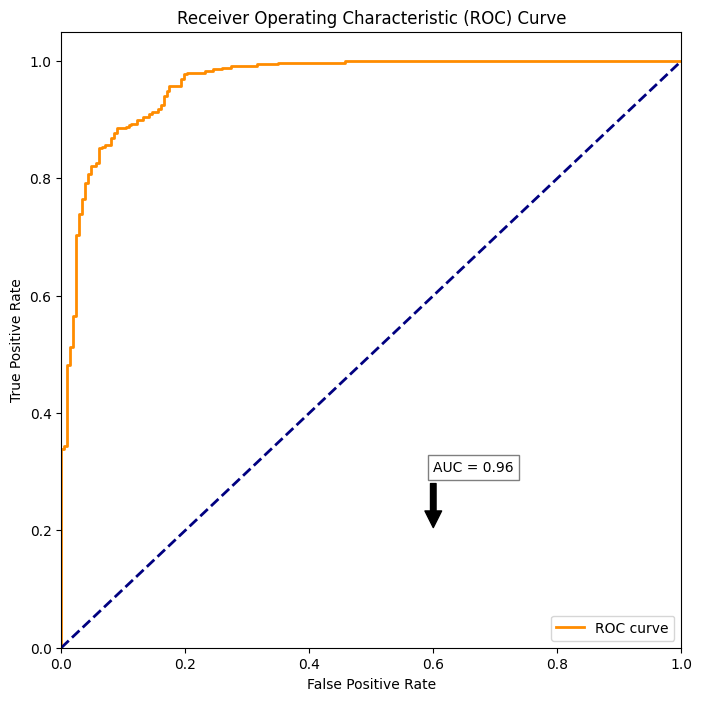

AUC: 0.9634599122667935


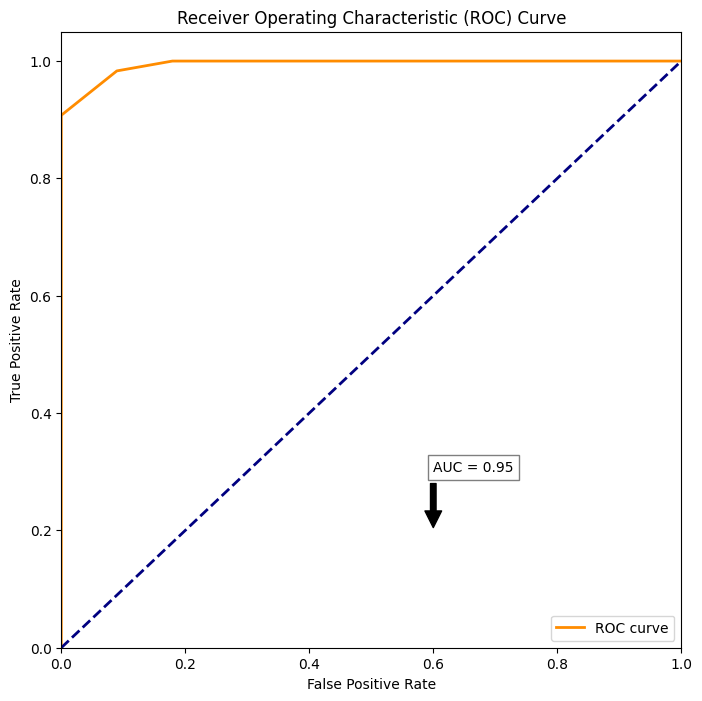

Probability Cutoff: 0.0
Confusion Matrix:
 [[  0 212]
 [  0 357]]
TPR: 1.0
FPR: 1.0

---

Probability Cutoff: 0.1111111111111111
Confusion Matrix:
 [[174  38]
 [  0 357]]
TPR: 1.0
FPR: 0.1792452830188679

---

Probability Cutoff: 0.2222222222222222
Confusion Matrix:
 [[174  38]
 [  0 357]]
TPR: 1.0
FPR: 0.1792452830188679

---

Probability Cutoff: 0.3333333333333333
Confusion Matrix:
 [[174  38]
 [  0 357]]
TPR: 1.0
FPR: 0.1792452830188679

---

Probability Cutoff: 0.4444444444444444
Confusion Matrix:
 [[193  19]
 [  6 351]]
TPR: 0.9831932773109243
FPR: 0.08962264150943396

---

Probability Cutoff: 0.5555555555555556
Confusion Matrix:
 [[193  19]
 [  6 351]]
TPR: 0.9831932773109243
FPR: 0.08962264150943396

---

Probability Cutoff: 0.6666666666666666
Confusion Matrix:
 [[193  19]
 [  6 351]]
TPR: 0.9831932773109243
FPR: 0.08962264150943396

---

Probability Cutoff: 0.7777777777777777
Confusion Matrix:
 [[212   0]
 [ 33 324]]
TPR: 0.907563025210084
FPR: 0.0

---

Probability Cutoff: 0.8

In [ ]:
def main():

    X,y = load_breast_cancer().data,load_breast_cancer().target
    X_normalized = np.apply_along_axis(min_max_scale,axis=0,arr=X)
    X_train, y_train, X_test, y_test = train_test_split(X_normalized, y, train_ratio = 0.8)
    model = myLogisticRegression()
    model2 = knn()
    # training without ridge
    learned_weights = model.gradient_descent(X_train, y_train, lr=0.01, tol=0.01)
    cm_values, auc_value, tpr_values, fpr_values = model.evaluate_classification_model(y, X @ learned_weights, probability_cutoffs=np.linspace(0, 1, 10))
    print("AUC:", auc_value)
    #hyperparameter tuning and cross-validation
    lambds = np.linspace(0.001,1, num=10)
    best_lambda = cross_validate(X_train, y_train, model, lambds, 4)
    print("BEST LAMBDA:",best_lambda)
    # training with best lambda
    learned_weights_with_reg = model.gradient_descent(X_train, y_train, lr=0.01, tol=0.01, lambda_reg=best_lambda)
    cm_values, auc_value, tpr_values, fpr_values = model.evaluate_classification_model(y, X @ learned_weights_with_reg, probability_cutoffs=np.linspace(0, 1, 10))
    print("AUC:", auc_value)
    # Use the custom KNN function
    y_pred, y_prob = model2.myKnn(X, y, 3)
    cm_values, auc_value, tpr_values, fpr_values = model2.evaluate_classification_model(y, y_pred, probability_cutoffs=np.linspace(0, 1, 10))
    for i, cutoff in enumerate(np.linspace(0, 1, 10)):
        print(f"Probability Cutoff: {cutoff}")
        print("Confusion Matrix:\n", cm_values[i])
        print("TPR:", tpr_values[i])
        print("FPR:", fpr_values[i])
        print("\n---\n")
    print("AUC:", auc_value)


if __name__ == "__main__":
    main()
